In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np, scipy.stats as st
import statsmodels.stats.api as sms

from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ud2f2xgo because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
df = pd.read_csv('olist_processado.csv')
df.head(2)

,customer_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,product_id,price,review_id,review_score,customer_lat,customer_long,product_category_name,quantidade_item
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,88b8b52d46df026a9d1ad2136a59b30b,4,-20.500253,-47.400367,moveis_escritorio,1
1,8912fc0c3bbf1e2fbf35819e21706718,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,1,a9516a079e37a9c9c36b9b78b10169e8,112.99,7fc63200f12eebb5f387856afdd63db8,1,-2.441535,-54.720801,moveis_escritorio,2


In [3]:
df['customer_id_code'] = df.customer_id.astype('category').cat.codes
df['product_id_code'] = df.product_id.astype('category').cat.codes

In [4]:
split_value = int(len(df) * 0.80)
train_data = df[:split_value]
test_data = df[split_value:]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


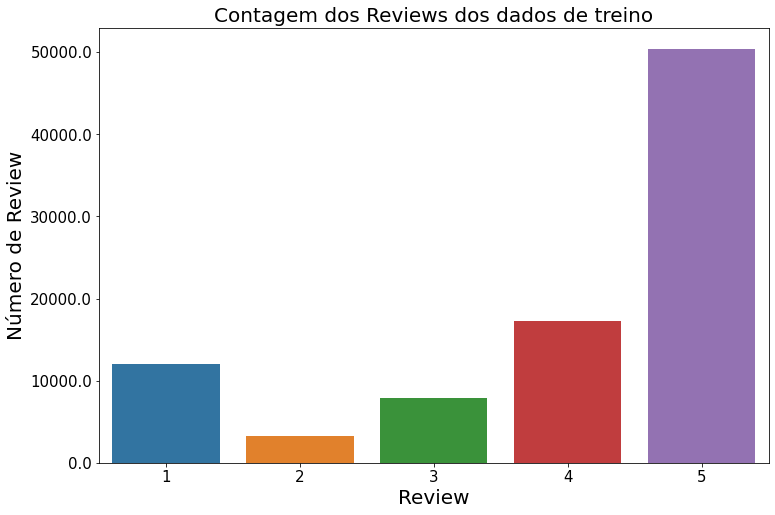

In [5]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="review_score", data=train_data)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Contagem dos Reviews dos dados de treino", fontsize = 20)
plt.xlabel("Review", fontsize = 20)
plt.ylabel("Número de Review", fontsize = 20)
plt.show()

In [6]:
no_rated_products_per_cliente = train_data.groupby(by = "customer_id")["review_score"].count().sort_values(ascending = False)
no_rated_products_per_cliente.head()

customer_id
f4c13379ddd0ed4f4fc1c0b49c2c5e51    22
be1c4e52bb71e0c54b11a26b8e8d59f2    22
be1b70680b9f9694d8c70f41fa3dc92b    20
d6646ea91d8cd9fc7e6882a7068779d4    20
62ff903909cb86e2b07156a6d7cc48da    18
Name: review_score, dtype: int64

In [7]:
no_ratings_per_product = train_data.groupby(by = "product_id")["review_score"].count().sort_values(ascending = False)
no_ratings_per_product.head()

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    528
99a4788cb24856965c36a24e339b6058    527
422879e10f46682990de24d770e7f83d    496
368c6c730842d78016ad823897a372db    413
389d119b48cf3043d311335e499d9c6b    399
Name: review_score, dtype: int64

In [8]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.review_score, (df.customer_id_code, df.product_id_code)))
    return sparse_data

In [9]:
train_sparse_data = get_user_item_sparse_matrix(train_data)

In [10]:
test_sparse_data = get_user_item_sparse_matrix(test_data)

In [11]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Média de Review Global: {}".format(global_average_rating))

Média de Review Global: 4.495230908168693


In [12]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

In [13]:
average_rating_user = get_average_rating(train_sparse_data, True)

In [14]:
avg_rating_product = get_average_rating(train_sparse_data, False)

In [15]:
total_users = len(np.unique(df["customer_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
                  
print("Total no. de Clientes = {}".format(total_users))
print("No. de Clientes no 'train data'= {}".format(train_users))
print("No. de Clientes não presentes no 'train data' = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. de Clientes = 97277
No. de Clientes no 'train data'= 77629
No. de Clientes não presentes no 'train data' = 19648(20.0%)


In [16]:
total_produtos = len(np.unique(df["product_id"]))
train_produtos = len(avg_rating_product)
uncommonProdutos = total_produtos - train_produtos
                  
print("Total no. de Produtos = {}".format(total_produtos))
print("No. de Produtos no 'train data' = {}".format(train_produtos))
print("No. de Clientes no 'train data' = {}({}%)".format(uncommonProdutos, np.round((uncommonProdutos/total_produtos)*100), 2))

Total no. de Produtos = 32400
No. de Produtos no 'train data' = 17364
No. de Clientes no 'train data' = 15036(46.0%)


In [17]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)
    
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr 

In [18]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

In [19]:
similar_user_matrix[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [20]:
df.tail()

,customer_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,product_id,price,review_id,review_score,customer_lat,customer_long,product_category_name,quantidade_item,customer_id_code,product_id_code
113617,f6c6d3e1e20969a5eed982163f959719,sao paulo,SP,b2f58affcc178fea2daaf834f1acff5e,2018-07-14 14:08:11,1,9682ad2500ae8b2609e6a88eb0cbc5bb,99.90,17e0e42ddf0dd7ebceff457b7c1da303,3,-23.560757,-46.623184,casa_conforto,1,93851,19008
113618,da37711b17efd5f2539e8196ab215f04,sao paulo,SP,c8203bb57639618630affac9e8e923dd,2017-03-27 23:04:18,1,aea06073397f809424f946979354c9f0,19.99,f3642bae4843d919c4c53ec1ff8fe26d,4,-23.638750,-46.640473,pet_shop,1,83135,22016
113619,184e0c2cfc746789643521df0e9ff904,sao miguel do guama,PA,45b3000bcd10464ac178f32cd783fc83,2017-12-07 23:55:46,1,bbf975bffd2ae9ee52f513ae5c8a4b27,250.00,6dfe34036fd1f79225daeaca9cf083c2,4,-1.612028,-47.476949,beleza_saude,1,9277,23776
113620,821a7275a08f32975caceff2e08ea262,sao paulo,SP,49645a8902c1ba980836b7bff991d69f,2018-04-04 17:50:52,1,f6e0a9ce8a6e91c3a0ca2d3005911d20,84.90,260447daa5d738ced8f4e0bbee8a08a2,5,-23.624169,-46.743793,fashion_bolsas_e_acessorios,1,49425,31238
113621,1ed0c832c2dd99570a59260e71768bdf,bom repouso,MG,51c6d2f460589fa7b65f2da51e860206,2017-11-14 12:04:09,1,c98bf47f7bea8f3aee82fa023786b8a1,167.99,603f2873842a6975a43c54d305397d69,1,-22.477212,-46.142185,eletronicos,1,11767,25533


In [21]:
product_id = df.index[df['product_id_code'] == 25533]

In [22]:
product_id[0]

113621

In [23]:
def compute_product_similarity_count(sparse_matrix, df, product_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_products = df.loc[product_id][6], similarity[product_id].count_nonzero()
    return no_of_similar_products

In [24]:
df.loc[113621]

customer_id                 1ed0c832c2dd99570a59260e71768bdf
customer_city                                    bom repouso
customer_state                                            MG
order_id                    51c6d2f460589fa7b65f2da51e860206
order_purchase_timestamp                 2017-11-14 12:04:09
order_item_id                                              1
product_id                  c98bf47f7bea8f3aee82fa023786b8a1
price                                                 167.99
review_id                   603f2873842a6975a43c54d305397d69
review_score                                               1
customer_lat                                        -22.4772
customer_long                                       -46.1422
product_category_name                            eletronicos
quantidade_item                                            1
customer_id_code                                       11767
product_id_code                                        25533
Name: 113621, dtype: obj

In [25]:
similar_products = compute_product_similarity_count(train_sparse_data, df, 25533)
print("Produtos Similares = {}".format(similar_products))

Produtos Similares = ('d5991653e037ccb7af6ed7d94246b249', 0)


In [26]:
data = range(len(df.customer_id))
st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data))
sms.DescrStatsW(data).tconfint_mean()
df_sample = df.sample(n=10000)

In [27]:
split_value = int(len(df_sample) * 0.80)
train_data_sample = df_sample[:split_value]
test_data_sample = df_sample[split_value:]

In [28]:
print("Train_data: {} ".format(len(train_data_sample)))
print("Test_data: {}".format(len(test_data_sample)))

Train_data: 8000 
Test_data: 2000


In [29]:
train_sparse_data_sample = get_user_item_sparse_matrix(train_data_sample)
test_sparse_data_sample = get_user_item_sparse_matrix(test_data_sample)

In [30]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_products):
    users, products, review_score = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_products = np.unique(products)
    np.random.seed(15)
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    product = np.random.choice(uniq_products, no_of_products, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(products, products))
    sparse_matrix = sparse.csr_matrix((review_score[mask], (users[mask], products[mask])), shape = (max(user)+1, max(product)+1))
    
    return sparse_matrix

In [31]:
'''users, products, review_score = sparse.find(test_sparse_data_sample)
uniq_users = np.unique(users)
uniq_products = np.unique(products)
np.random.seed(15)'''

'users, products, review_score = sparse.find(test_sparse_data_sample)\nuniq_users = np.unique(users)\nuniq_products = np.unique(products)\nnp.random.seed(15)'

In [32]:
#len(uniq_users)

In [33]:
#len(uniq_products)

In [34]:
'''user = np.random.choice(uniq_users, 170, replace = False)
product = np.random.choice(uniq_products, 1698, replace = True)
mask = np.logical_and(np.isin(users, user), np.isin(products, products))
sparse_matrix = sparse.csr_matrix((review_score[mask], (users[mask], products[mask])), shape = (max(user)+1, max(product)+1))
'''    

'user = np.random.choice(uniq_users, 170, replace = False)\nproduct = np.random.choice(uniq_products, 1698, replace = True)\nmask = np.logical_and(np.isin(users, user), np.isin(products, products))\nsparse_matrix = sparse.csr_matrix((review_score[mask], (users[mask], products[mask])), shape = (max(user)+1, max(product)+1))\n'

In [45]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data_sample, 7000, 5454)

In [49]:
test_sample_sparse_matrix = get_sample_sparse_matrix(test_sparse_data_sample, 170, 1698)

In [50]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_review = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_products = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_products, sample_train_reviews = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open("new_features.csv", mode = "w")
    
    for user, product, review in zip(sample_train_users, sample_train_products, sample_train_reviews):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(product)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())
        
        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        reviews = sample_sparse_matrix[indices, product].toarray().ravel()
        top_similar_user_reviews = list(reviews[reviews != 0][:5])
        top_similar_user_reviews.extend([global_avg_review[product]] * (5 - len(reviews)))
        similar_arr.extend(top_similar_user_reviews)
        
        similar_products = cosine_similarity(sample_sparse_matrix[:,product].T, sample_sparse_matrix.T).ravel()
        similar_products_indices = np.argsort(-similar_products)[1:]
        similar_products_reviews = sample_sparse_matrix[user, similar_products_indices].toarray().ravel()
        top_similar_product_reviews = list(similar_products_reviews[similar_products_reviews != 0][:5])
        top_similar_product_reviews.extend([global_avg_users[user]] * (5-len(top_similar_product_reviews)))
        similar_arr.extend(top_similar_product_reviews)
        
        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_products[product])
        similar_arr.append(review)
        
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', names = ["user_id", "product_id", "gloabl_average", "similar_user_review1", 
                                                               "similar_user_review2", "similar_user_review3", 
                                                               "similar_user_review4", "similar_user_review5", 
                                                               "similar_product_review1", "similar_product_review2", 
                                                               "similar_product_review3", "similar_product_review4", 
                                                               "similar_product_review5", "user_average", 
                                                               "product_average", "review"]) 
    return new_features_df

In [65]:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)


(7037, 16)

In [ ]:
train_new_similar_features.shape

In [64]:
test_new_similar_features = create_new_similar_features(test_sample_sparse_matrix)
test_new_similar_features.shape

(170, 16)

In [54]:
x_train = train_new_similar_features.drop(["user_id", "product_id", "review"], axis = 1)
x_test = test_new_similar_features.drop(["user_id", "product_id", "review"], axis = 1)
y_train = train_new_similar_features["review"]
y_test = test_new_similar_features["review"]

In [55]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [56]:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

[23:21:37] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=10, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=False,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [57]:
y_pred_test = clf.predict(x_test)

/usr/local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


In [61]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()

ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.

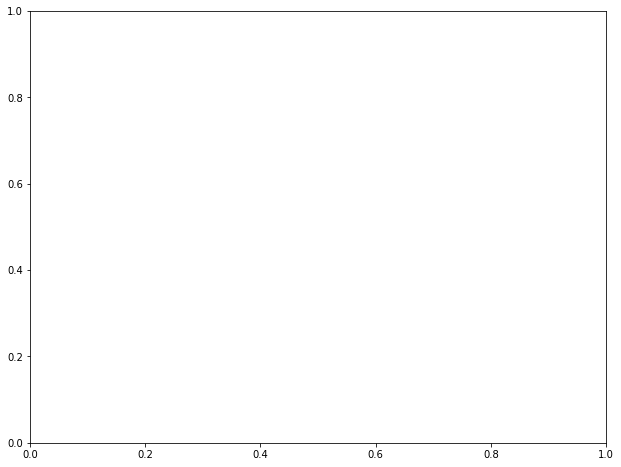

In [63]:
plot_importance(xgb, clf)